# Import of libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd    
from shapely.geometry import Point    
from sklearn.model_selection import train_test_split   
from sklearn.preprocessing import StandardScaler  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_squared_error, r2_score


warnings.filterwarnings('ignore')

# Loading and processing RMQS1_analyses_composites data

In [2]:
RMQS_carbon = pd.read_excel("data/RMQS1_analyses_composites.xlsx")
print("Display the 5 first rows to understand the structure")
RMQS_carbon.head()

Display the 5 first rows to understand the structure


,no_campagne,id_site,date_complete,code_dept,site_officiel,x_theo,y_theo,type_profil_rmqs,no_couche,profondeur_hz_sup,...,hg_tot_79,cond_elec_119_1,cond_elec_129,cl_sol_195,ca_sol_194,k_sol_201,mg_sol_194,na_sol_201,n_tot_sol_221,s_sol_202
0,1,6,2002-09-10,59,True,652326.99,7101219.71,C,1,0,...,0.066,ND,ND,ND,ND,ND,ND,ND,ND,ND
1,1,6,2002-09-10,59,True,652326.99,7101219.71,C,2,29,...,0.01,ND,ND,ND,ND,ND,ND,ND,ND,ND
2,1,7,2002-09-02,59,True,668319.25,7101085.53,C,1,0,...,0.037,ND,ND,ND,ND,ND,ND,ND,ND,ND
3,1,7,2002-09-02,59,True,668319.25,7101085.53,C,2,31,...,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND
4,1,8,2003-07-02,62,True,604216.81,7085629.01,C,1,0,...,0.036,ND,ND,ND,ND,ND,ND,ND,ND,ND


In [3]:
print('The dataframe contains {} lines and {} columns.\n'.format(RMQS_carbon.shape[0], RMQS_carbon.shape[1]))

The dataframe contains 4148 lines and 68 columns.



There are many colums that measures important informations, but for this project, the only columns we're interested on are:

    ○ id_site and no_couche: we'll use them to merge the two datasets
    ○ Our target variable: carbone_16_5_1
    ○ The features:
    
        ■ Soil composition: to be calculated
        ■ Soil ph: ph_eau_6_1
       

Let's select relevant columns for the modeling process.

## Selection of columns

In [4]:
# Display column names 
# RMQS_carbon.columns

In [5]:
# filter needed columns
RMQS_carbon_filtered = RMQS_carbon[["id_site","no_couche","carbone_16_5_1",'argile', 
                                    'limon_fin', 'limon_grossier',"ph_eau_6_1"]]
RMQS_carbon_filtered.head()

,id_site,no_couche,carbone_16_5_1,argile,limon_fin,limon_grossier,ph_eau_6_1
0,6,1,12.92,247,122,131,8.16
1,6,2,5.247,312,184,128,8.42
2,7,1,14.3,186,134,232,8.2
3,7,2,7.45,333,261,256,8.3
4,8,1,37.513,313,166,195,7.56


In [6]:
# information on the dataset
RMQS_carbon_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_site         4148 non-null   int64 
 1   no_couche       4148 non-null   int64 
 2   carbone_16_5_1  4148 non-null   object
 3   argile          4148 non-null   object
 4   limon_fin       4148 non-null   object
 5   limon_grossier  4148 non-null   object
 6   ph_eau_6_1      4148 non-null   object
dtypes: int64(2), object(5)
memory usage: 227.0+ KB


The dataset indicates that some column data types are non-numeric when they should be numeric, necessitating a transformation. A glance at the Excel file reveals that some entries contain the value "ND." For example:

In [7]:
RMQS_carbon_filtered[RMQS_carbon_filtered['limon_grossier'] =="ND"]

,id_site,no_couche,carbone_16_5_1,argile,limon_fin,limon_grossier,ph_eau_6_1
151,91,9,359,ND,ND,ND,3.9
325,193,9,285,ND,ND,ND,3.8
328,194,9,293,ND,ND,ND,4
333,196,9,238,ND,ND,ND,4.1
403,232,9,291,ND,ND,ND,5.21
...,...,...,...,...,...,...,...
4084,10534,9,154,ND,ND,ND,3.57
4092,10797,9,180,ND,ND,ND,4.6
4114,11136,2,ND,ND,ND,ND,ND
4124,11314,9,242,ND,ND,ND,7.05


Assuming "ND" means "No Defines", I propose treating these values as null values ("NA").

Traditional approaches for handling null values include replacing them with the mean, median, or deleting them.

In [8]:
# Creation of a function to transform columns 
def replace_nd_values(df, column):
    """
    Replaces "ND" values in a specified column of a DataFrame with other values in that column.

    :param df: The DataFrame in which to perform the replacement.
    :param column: The name of the column where "ND" should be replaced.
    :return: DataFrame with the values replaced.
    """
    # Replace "ND" with NaN
    df.loc[df[column] == 'ND', column] = np.nan

    # Convert the column to numeric type
    df[column] = pd.to_numeric(df[column])

#     # Calculate the mean of the column, ignoring NaN values
#     mean_value = df[column].mean()

#     # Replace NaN values with the calculated mean
#     df[column].fillna(mean_value, inplace=True)

    return df

In [9]:
# Use the function on the column
df_numeric = replace_nd_values(RMQS_carbon_filtered, 'limon_grossier')
df_numeric = replace_nd_values(RMQS_carbon_filtered, 'limon_fin')
df_numeric = replace_nd_values(RMQS_carbon_filtered, 'argile')
df_numeric = replace_nd_values(RMQS_carbon_filtered, 'ph_eau_6_1')
df_numeric = replace_nd_values(RMQS_carbon_filtered, 'carbone_16_5_1')
df_numeric.head()

,id_site,no_couche,carbone_16_5_1,argile,limon_fin,limon_grossier,ph_eau_6_1
0,6,1,12.920,247.0,122.0,131.0,8.16
1,6,2,5.247,312.0,184.0,128.0,8.42
2,7,1,14.300,186.0,134.0,232.0,8.20
3,7,2,7.450,333.0,261.0,256.0,8.30
4,8,1,37.513,313.0,166.0,195.0,7.56


In [10]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_site         4148 non-null   int64  
 1   no_couche       4148 non-null   int64  
 2   carbone_16_5_1  4143 non-null   float64
 3   argile          3991 non-null   float64
 4   limon_fin       3991 non-null   float64
 5   limon_grossier  3991 non-null   float64
 6   ph_eau_6_1      4143 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 227.0 KB


##### ■ calculation of Soil composition 
this is defined as the % of clay and silt, and in this sheet is defined as the sum of argile, limon_fin &limon_grossier / 1000 (from RMQS1_analyses_composites)


In [11]:
# Now calculate the soil composition
def sum_col(df,x,y,z):
    return (df[x]+ df[y] +df[z])/1000
    
df_numeric["soil_composition"] = sum_col(df_numeric,'argile','limon_fin','limon_grossier')

# Display the first few rows to verify
df_numeric.head()


,id_site,no_couche,carbone_16_5_1,argile,limon_fin,limon_grossier,ph_eau_6_1,soil_composition
0,6,1,12.920,247.0,122.0,131.0,8.16,0.500
1,6,2,5.247,312.0,184.0,128.0,8.42,0.624
2,7,1,14.300,186.0,134.0,232.0,8.20,0.552
3,7,2,7.450,333.0,261.0,256.0,8.30,0.850
4,8,1,37.513,313.0,166.0,195.0,7.56,0.674


In [12]:
# information on the dataset
df_numeric.describe()

,id_site,no_couche,carbone_16_5_1,argile,limon_fin,limon_grossier,ph_eau_6_1,soil_composition
count,4148.000000,4148.000000,4143.000000,3991.000000,3991.000000,3991.000000,4143.000000,3991.000000
mean,1327.566056,1.747107,28.694403,247.980205,224.791531,176.208720,6.446213,0.648980
std,1537.216034,1.519245,56.362117,135.733115,96.676860,115.236343,1.348583,0.238764
min,6.000000,1.000000,0.590000,2.000000,1.000000,1.000000,3.500000,0.012000
25%,579.750000,1.000000,7.675000,154.000000,159.000000,92.000000,5.345000,0.479500
50%,1153.500000,1.000000,13.800000,216.000000,228.000000,145.000000,6.300000,0.699000
75%,1753.250000,2.000000,25.087500,322.000000,290.000000,237.000000,7.800000,0.845000
max,20797.000000,9.000000,459.000000,851.000000,595.000000,555.000000,9.200000,0.998000


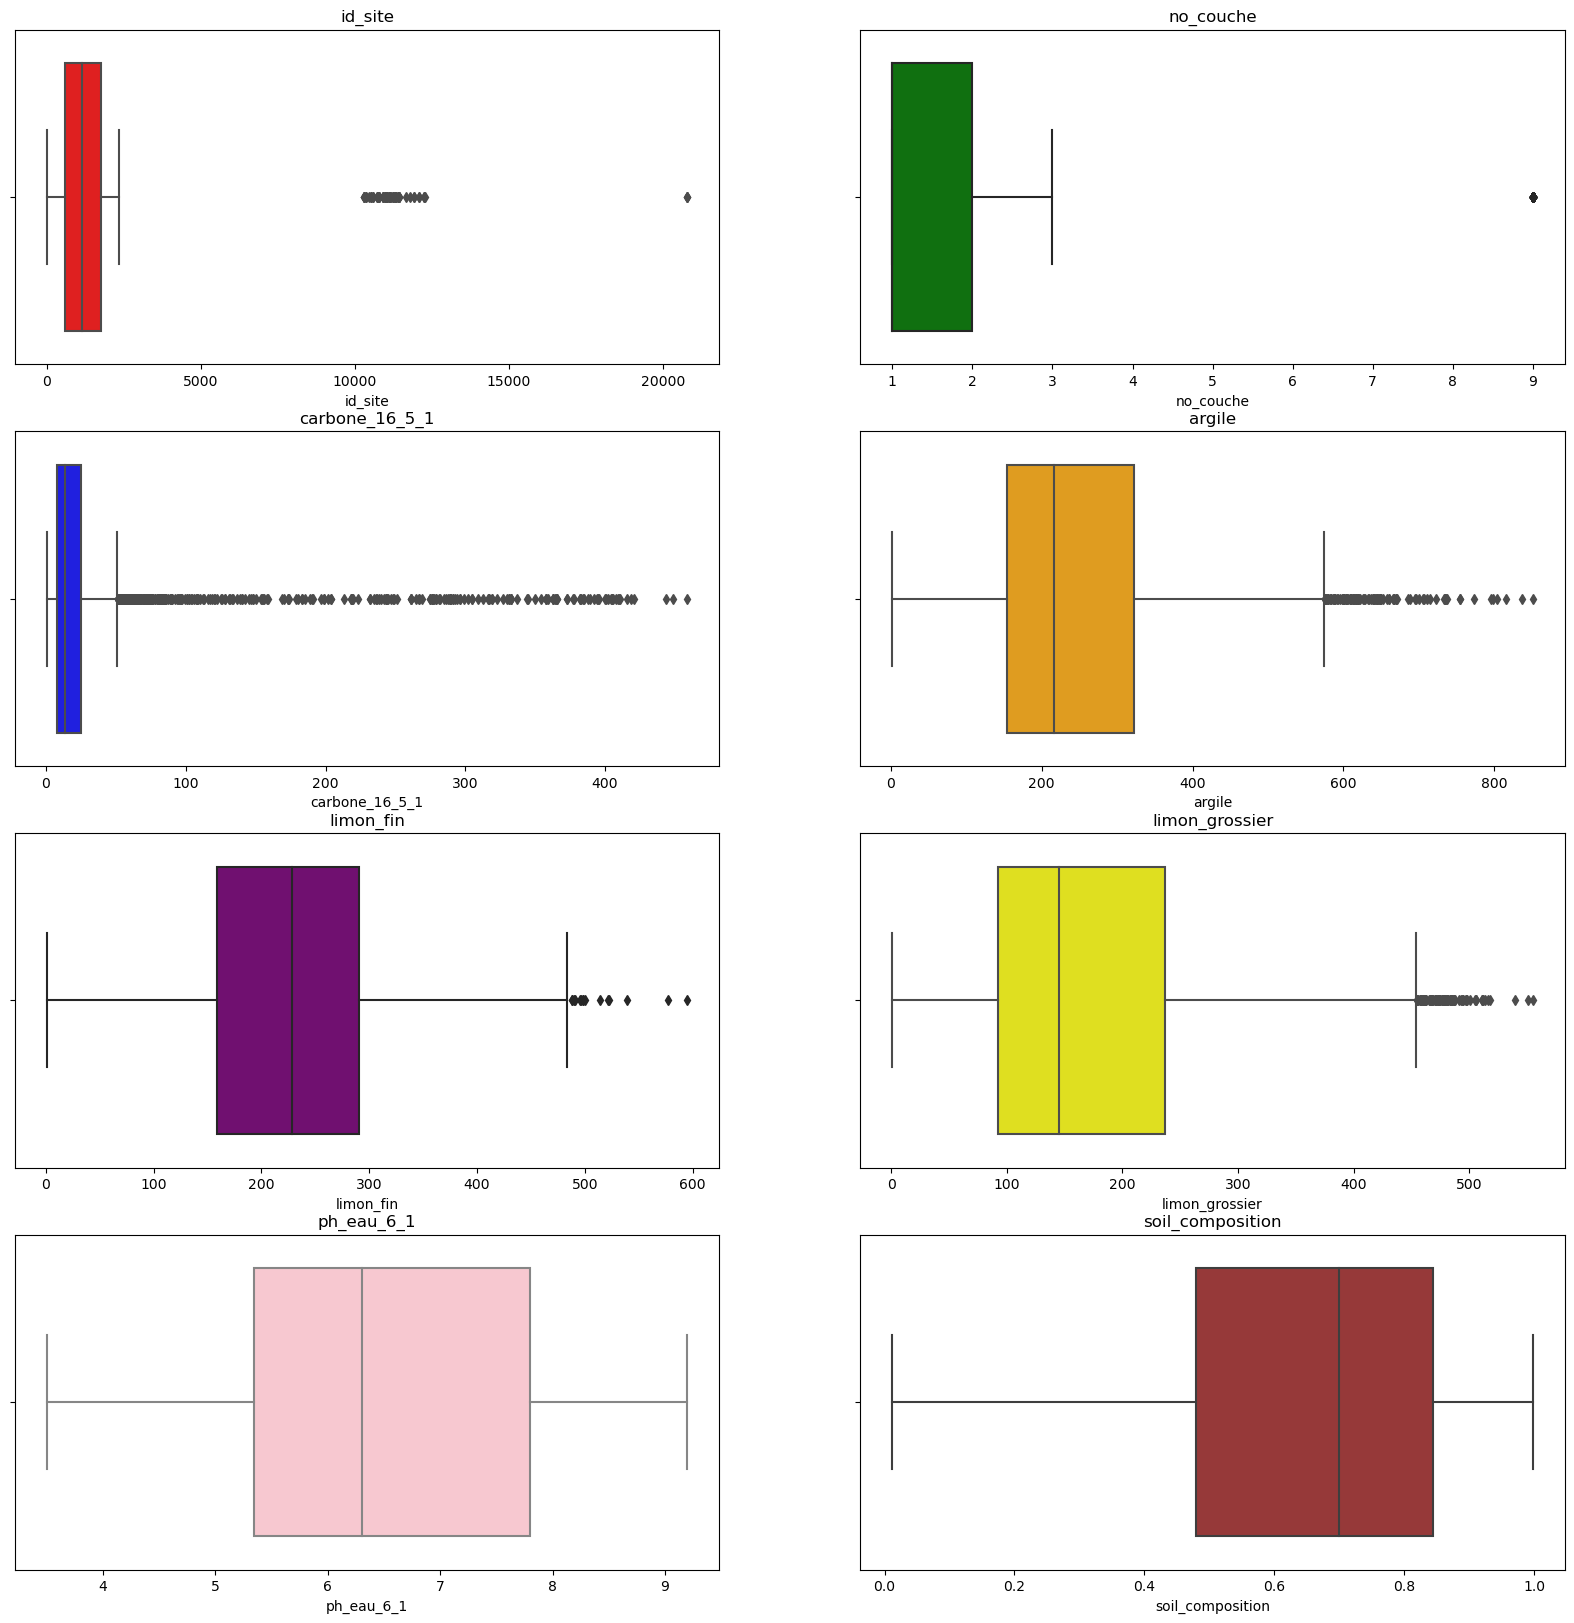

In [13]:
# create box plots for all numeric columns
plt.figure(figsize=(20, 20))

colors = ['red', 'green', 'blue', 'orange', 'purple','yellow','pink','brown']
numeric_cols = list(df_numeric.columns)

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df_numeric[col], color=colors[i])
    plt.title(col)
plt.show()

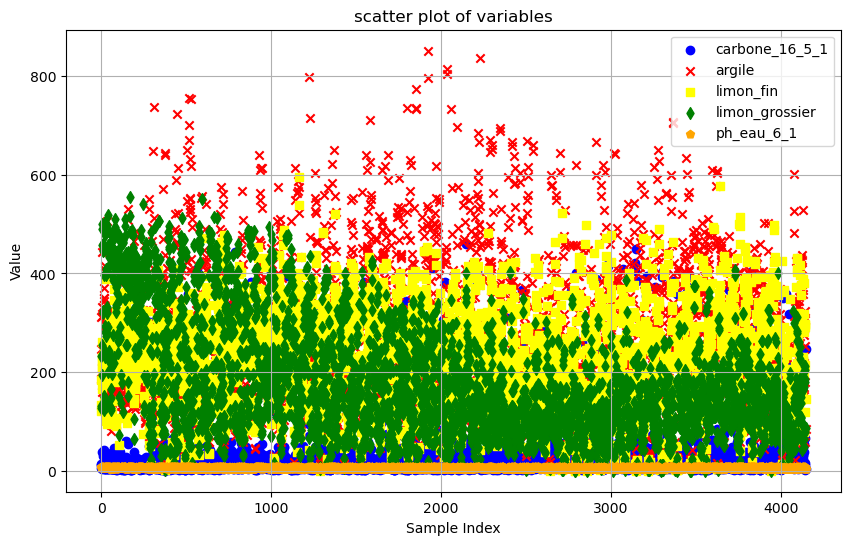

In [14]:
# Create a scatter plot  
plt.figure(figsize=(10, 6))  
plt.scatter(range(len(df_numeric["argile"])), df_numeric["carbone_16_5_1"], color='blue', label='carbone_16_5_1', marker='o')  
plt.scatter(range(len(df_numeric["argile"])),df_numeric["argile"], color='red', label='argile', marker='x')  
plt.scatter(range(len(df_numeric["argile"])),df_numeric["limon_fin"], color='yellow', label='limon_fin', marker='s')
plt.scatter(range(len(df_numeric["argile"])),df_numeric["limon_grossier"], color='green', label='limon_grossier', marker='d')
plt.scatter(range(len(df_numeric["argile"])),df_numeric["ph_eau_6_1"], color='orange', label='ph_eau_6_1', marker='p')

# Adding titles and labels  
plt.title('scatter plot of variables')  
plt.xlabel('Sample Index')  
plt.ylabel('Value')  
plt.legend()  
plt.grid()  

# Show the plot  
plt.show()

# Loading and processing RMQS1_occupation_nommatp_nomsol data

In [15]:
RMQS_occupation = pd.read_excel("data/RMQS1_occupation_nommatp_nomsol.xlsx")
print("Display the 5 first rows to understand the structure")
RMQS_occupation.head()

Display the 5 first rows to understand the structure


,no_campagne,id_site,date_complete,insee_commune,nom_commune,code_dept,site_officiel,x_theo,y_theo,classe_mat1p_million_dexpert,...,rp_95_nom,rp_2008_nom,rp_95_ger,signific_ger_95,rp_2008_ger,signific_ger_2008,occupation1,desc_code_occupation1,occupation3,desc_code_occupation3
0,1,6,2002-09-10 00:00:00,59016,ARMBOUTS-CAPPEL,59,1,652326.99,7101219.71,120,...,"THALASSOSOL-REDOXISOL limono-sablo-argileux, b...",ND,156,THALASSOSOL-REDOXISOL,ND,ND,1.0,successions culturales,120.0,grandes cultures et prairies courte duree
1,1,7,2002-09-02 00:00:00,59404,LES MOERES,59,1,668319.25,7101085.53,120,...,THALASSOSOL-REDOXISOL limoneux issu d'alluvion...,ND,156,THALASSOSOL-REDOXISOL,ND,ND,1.0,successions culturales,112.0,systeme de rotations sans prairie sans intercu...
2,1,8,2003-07-02 00:00:00,62806,TARDINGHEN,62,1,604216.81,7085629.01,230,...,"CALCOSOL-REDOXISOL argileux, issu d'une marne,...",ND,29,CALCOSOL-REDOXISOL,ND,ND,2.0,surfaces toujours en herbe,220.0,STH > 10 ans naturelle ou semee
3,1,9,2003-09-16 00:00:00,62397,GUINES,62,1,620208.83,7085495.39,510,...,"BRUNISOL luvique, limoneux, issu de limon loes...",ND,16,BRUNISOL,ND,ND,1.0,successions culturales,113.0,systeme de rotations sans prairie avec intercu...
4,1,10,2003-09-17 00:00:00,62906,ZUTKERQUE,62,1,636200.84,7085361.59,510,...,"BRUNISOL-REDOXISOL luvique, issu de depots red...",ND,21,BRUNISOL-REDOXISOL,ND,ND,1.0,successions culturales,112.0,systeme de rotations sans prairie sans intercu...


In [16]:
print('Dimensions of the occupation dataframe are respectively observations: {}, columns: {}\n'.format(RMQS_occupation.shape[0], RMQS_occupation.shape[1]))

Dimensions of the occupation dataframe are respectively observations: 2175, columns: 25



## Selection of columns in RMQS1_occupation_nommatp_nomsol

 ■ Vegetation cover 
 
        ■ Location 

In [17]:
RMQS_occupation.columns

Index(['no_campagne', 'id_site', 'date_complete', 'insee_commune',
       'nom_commune', 'code_dept', 'site_officiel', 'x_theo', 'y_theo',
       'classe_mat1p_million_dexpert', 'libelle_mat1p_million_dexpert',
       'classe_mat2p_million_dexpert', 'libelle_mat2p_million_dexpert',
       'classe_mat3p_million_dexpert', 'libelle_mat3p_million_dexpert',
       'rp_95_nom', 'rp_2008_nom', 'rp_95_ger', 'signific_ger_95',
       'rp_2008_ger', 'signific_ger_2008', 'occupation1',
       'desc_code_occupation1', 'occupation3', 'desc_code_occupation3'],
      dtype='object')

In [18]:
# Vegetation cover - this is defined in desc_code_occupation1 and desc_code_occupation3 
RMQS_occupation_filtered = RMQS_occupation[["id_site","desc_code_occupation1","desc_code_occupation3",
                                            'x_theo', 'y_theo']]
RMQS_occupation_filtered.head()

,id_site,desc_code_occupation1,desc_code_occupation3,x_theo,y_theo
0,6,successions culturales,grandes cultures et prairies courte duree,652326.99,7101219.71
1,7,successions culturales,systeme de rotations sans prairie sans intercu...,668319.25,7101085.53
2,8,surfaces toujours en herbe,STH > 10 ans naturelle ou semee,604216.81,7085629.01
3,9,successions culturales,systeme de rotations sans prairie avec intercu...,620208.83,7085495.39
4,10,successions culturales,systeme de rotations sans prairie sans intercu...,636200.84,7085361.59


# loading and processing SiteTempPrec data

■ SiteTempPrec which has a mapping of sites to average precipitation
        and temperature.

In [19]:
SiteTempPrec = pd.read_excel("data/SiteTempPrec.xlsx")
print("Display the 5 first rows to understand the structure")
SiteTempPrec.head()

Display the 5 first rows to understand the structure


,id_site,nom_commune,x_theo,y_theo,lat,lon,avg_temp,avg_prec
0,6.0,ARMBOUTS-CAPPEL,652326.99,7101219.71,51.004938,2.322287,10.275,58.55
1,7.0,LES MOERES,668319.25,7101085.53,51.004759,2.549635,10.275,58.55
2,8.0,TARDINGHEN,604216.81,7085629.01,50.859535,1.642270,10.275,58.55
3,9.0,GUINES,620208.83,7085495.39,50.860597,1.868951,10.275,58.55
4,10.0,ZUTKERQUE,636200.84,7085361.59,50.861246,2.095639,10.275,58.55


In [20]:
print('The dataframe contains {} lines and {} columns.\n'.format(SiteTempPrec.shape[0], SiteTempPrec.shape[1]))

The dataframe contains 2130 lines and 8 columns.



In [21]:
SiteTempPrec_filtered = SiteTempPrec[["id_site","avg_temp","avg_prec"]]
SiteTempPrec_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id_site   2130 non-null   float64
 1   avg_temp  2130 non-null   float64
 2   avg_prec  2130 non-null   float64
dtypes: float64(3)
memory usage: 50.1 KB


## Merge datasets

In [22]:
merged_df = pd.merge(RMQS_occupation_filtered, SiteTempPrec_filtered, how='outer', on='id_site')
print(len(merged_df))
merged_df.head()

2175


,id_site,desc_code_occupation1,desc_code_occupation3,x_theo,y_theo,avg_temp,avg_prec
0,6,successions culturales,grandes cultures et prairies courte duree,652326.99,7101219.71,10.275,58.55
1,7,successions culturales,systeme de rotations sans prairie sans intercu...,668319.25,7101085.53,10.275,58.55
2,8,surfaces toujours en herbe,STH > 10 ans naturelle ou semee,604216.81,7085629.01,10.275,58.55
3,9,successions culturales,systeme de rotations sans prairie avec intercu...,620208.83,7085495.39,10.275,58.55
4,10,successions culturales,systeme de rotations sans prairie sans intercu...,636200.84,7085361.59,10.275,58.55


In [23]:
data = pd.merge(df_numeric, merged_df, on='id_site')
print(len(df_numeric),len(merged_df),len(data))
data.head()

4148 2175 4146


,id_site,no_couche,carbone_16_5_1,argile,limon_fin,limon_grossier,ph_eau_6_1,soil_composition,desc_code_occupation1,desc_code_occupation3,x_theo,y_theo,avg_temp,avg_prec
0,6,1,12.920,247.0,122.0,131.0,8.16,0.500,successions culturales,grandes cultures et prairies courte duree,652326.99,7101219.71,10.275,58.55
1,6,2,5.247,312.0,184.0,128.0,8.42,0.624,successions culturales,grandes cultures et prairies courte duree,652326.99,7101219.71,10.275,58.55
2,7,1,14.300,186.0,134.0,232.0,8.20,0.552,successions culturales,systeme de rotations sans prairie sans intercu...,668319.25,7101085.53,10.275,58.55
3,7,2,7.450,333.0,261.0,256.0,8.30,0.850,successions culturales,systeme de rotations sans prairie sans intercu...,668319.25,7101085.53,10.275,58.55
4,8,1,37.513,313.0,166.0,195.0,7.56,0.674,surfaces toujours en herbe,STH > 10 ans naturelle ou semee,604216.81,7085629.01,10.275,58.55


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4146 entries, 0 to 4145
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_site                4146 non-null   object 
 1   no_couche              4146 non-null   int64  
 2   carbone_16_5_1         4141 non-null   float64
 3   argile                 3989 non-null   float64
 4   limon_fin              3989 non-null   float64
 5   limon_grossier         3989 non-null   float64
 6   ph_eau_6_1             4141 non-null   float64
 7   soil_composition       3989 non-null   float64
 8   desc_code_occupation1  4134 non-null   object 
 9   desc_code_occupation3  4134 non-null   object 
 10  x_theo                 4146 non-null   object 
 11  y_theo                 4146 non-null   float64
 12  avg_temp               4080 non-null   float64
 13  avg_prec               4080 non-null   float64
dtypes: float64(9), int64(1), object(4)
memory usage: 485.9+ 

In [25]:
df = data[['id_site', 'no_couche', 'carbone_16_5_1','ph_eau_6_1', 'soil_composition',
       'desc_code_occupation1', 'desc_code_occupation3', 'x_theo', 'y_theo',"avg_temp","avg_prec"]]

# Exploratory Data analyssis

## Null and duplicate values

In [26]:
df.isnull().sum()

id_site                    0
no_couche                  0
carbone_16_5_1             5
ph_eau_6_1                 5
soil_composition         157
desc_code_occupation1     12
desc_code_occupation3     12
x_theo                     0
y_theo                     0
avg_temp                  66
avg_prec                  66
dtype: int64

In [27]:
categorical_columns = df.select_dtypes(include=[object, 'category']).columns
df[categorical_columns] = df[categorical_columns].apply(lambda col: col.fillna(col.mode()[0]), axis=0)


In [28]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].apply(lambda col: col.fillna(col.mean()), axis=0)


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4146 entries, 0 to 4145
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_site                4146 non-null   int64  
 1   no_couche              4146 non-null   int64  
 2   carbone_16_5_1         4146 non-null   float64
 3   ph_eau_6_1             4146 non-null   float64
 4   soil_composition       4146 non-null   float64
 5   desc_code_occupation1  4146 non-null   object 
 6   desc_code_occupation3  4146 non-null   object 
 7   x_theo                 4146 non-null   float64
 8   y_theo                 4146 non-null   float64
 9   avg_temp               4146 non-null   float64
 10  avg_prec               4146 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 388.7+ KB


In [30]:
# # Fill NaN values with the most common value/mean  
# df['desc_code_occupation3'].fillna(df['desc_code_occupation3'].mode()[0], inplace=True)
# df['desc_code_occupation1'].fillna(df['desc_code_occupation1'].mode()[0], inplace=True)
# df['soil_composition'].fillna(df['soil_composition'].mean(), inplace=True)
# df['carbone_16_5_1'].fillna(df['carbone_16_5_1'].mean(), inplace=True)
# df['ph_eau_6_1'].fillna(df['ph_eau_6_1'].mean(), inplace=True)


In [31]:
df.isnull().sum()

id_site                  0
no_couche                0
carbone_16_5_1           0
ph_eau_6_1               0
soil_composition         0
desc_code_occupation1    0
desc_code_occupation3    0
x_theo                   0
y_theo                   0
avg_temp                 0
avg_prec                 0
dtype: int64

In [32]:
df.loc[df.duplicated()]

,id_site,no_couche,carbone_16_5_1,ph_eau_6_1,soil_composition,desc_code_occupation1,desc_code_occupation3,x_theo,y_theo,avg_temp,avg_prec


## Descriptive analysis

In [33]:
print("Descriptive Statistics:\n", df.describe())  


Descriptive Statistics:
             id_site    no_couche  carbone_16_5_1   ph_eau_6_1  \
count   4146.000000  4146.000000     4146.000000  4146.000000   
mean    1328.021225     1.747226       28.705108     6.445970   
std     1537.447081     1.519562       56.339587     1.348049   
min        6.000000     1.000000        0.590000     3.500000   
25%      580.250000     1.000000        7.682500     5.350000   
50%     1154.000000     1.000000       13.800000     6.300000   
75%     1753.750000     2.000000       25.124000     7.800000   
max    20797.000000     9.000000      459.000000     9.200000   

       soil_composition        x_theo        y_theo     avg_temp     avg_prec  
count       4146.000000  4.146000e+03  4.146000e+03  4146.000000  4146.000000  
mean           0.648856  6.615741e+05  6.614945e+06    10.193397    68.571272  
std            0.234193  2.167688e+05  2.350849e+05    11.514930    24.071329  
min            0.012000  1.065583e+05  6.057202e+06  -100.000000  -10

we can see the stat of eah variable.

## Categorical Analysis

In [34]:
print("All vegetation cover types in desc_code_occupation3 \n\n",df["desc_code_occupation3"].unique())

All vegetation cover types in desc_code_occupation3 

 ['grandes cultures et prairies courte duree'
 'systeme de rotations sans prairie sans interculture'
 'STH > 10 ans naturelle ou semee'
 'systeme de rotations sans prairie avec interculture' 'jachere fixe'
 'STH 6-10 ans semee' 'Surface toujours en herbe (STH)'
 'forets caducifoliees' 'monoculture' 'forets mixtes'
 'forets de coniferes' 'grandes cultures' 'peupleraies' 'maraa®chage'
 'vigne (en culture pure)' 'pelouse de parc' 'friches'
 'prairies humides et megaphorbiaies' 'milieux littoraux et halophiles'
 'fruits a\xa0 pepins' 'verger (culture pure)' 'Successions culturales'
 'landes et fruticees' 'vegetation de ceinture des bords des eaux'
 'pelouses alpines et subalpines'
 'STH peu productive ( parcours, landes, alpages)'
 'dunes cotieres et plages de sable' 'tourbieres et marais'
 'steppes et prairies calcaires seches' 'vergers â€“ autres cultures'
 'fruits a\xa0 coques' 'horticulture ornementale herbacee et ligneux'
 'milieux

In [35]:
print("5 most vegetation cover types in desc_code_occupation3 \n\n",df["desc_code_occupation3"].value_counts()[:5])

5 most vegetation cover types in desc_code_occupation3 

 systeme de rotations sans prairie sans interculture    846
STH > 10 ans naturelle ou semee                        741
forets caducifoliees                                   595
grandes cultures et prairies courte duree              361
forets mixtes                                          323
Name: desc_code_occupation3, dtype: int64


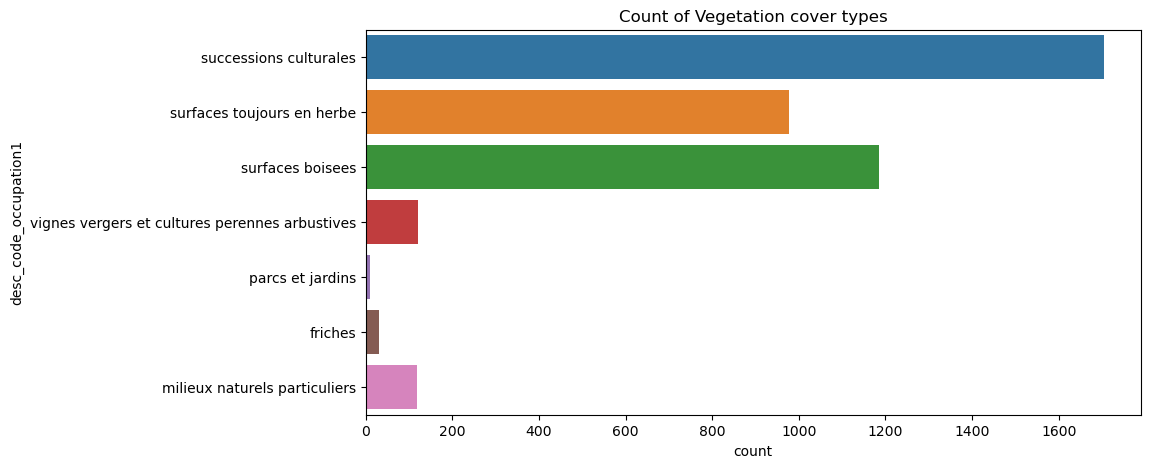

In [36]:
plt.figure(figsize=(10, 5))  
sns.countplot(y='desc_code_occupation1', data=df)  
plt.title('Count of Vegetation cover types')  
plt.show()  

The category "successions culturelles" has the highest count, indicating it is the most prevalent vegetation cover type in the dataset.
"surfaces toujours en herbe" and "surfaces boisées" also show significant counts, but they are lower than "successions culturelles."
The remaining categories, such as "vignes vergers et cultures perennes arbustives," "parcs et jardins," "friches," and "milieux naturels particuliers," have comparatively lower counts.

## Data visualisation

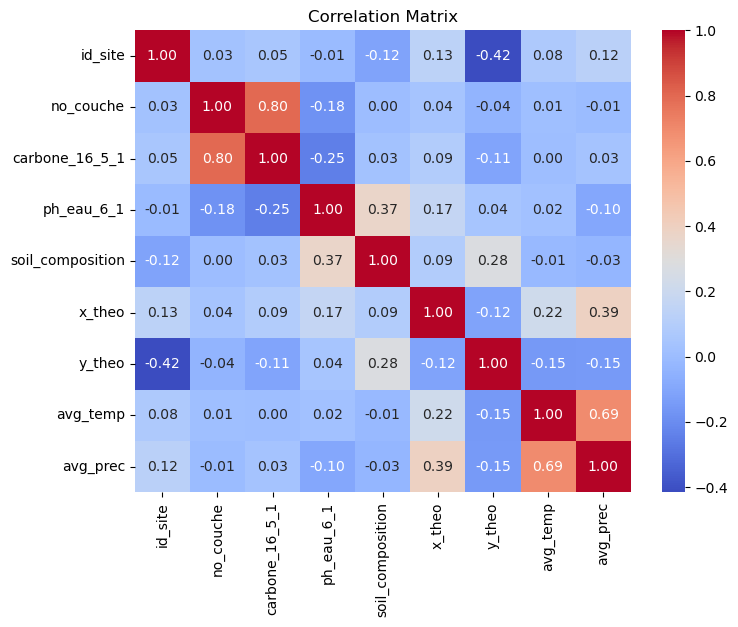

In [37]:
# Correlation Matrix  
plt.figure(figsize=(8, 6))  
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')  
plt.title('Correlation Matrix')  
plt.show()  

Overall, the correlations in this matrix indicate mostly weak relationships among the variables, with the exception of a moderate correlation between pH level and soil composition. The weak negative correlation between the number of layers and carbon values may warrant further investigation.

<Figure size 800x600 with 0 Axes>

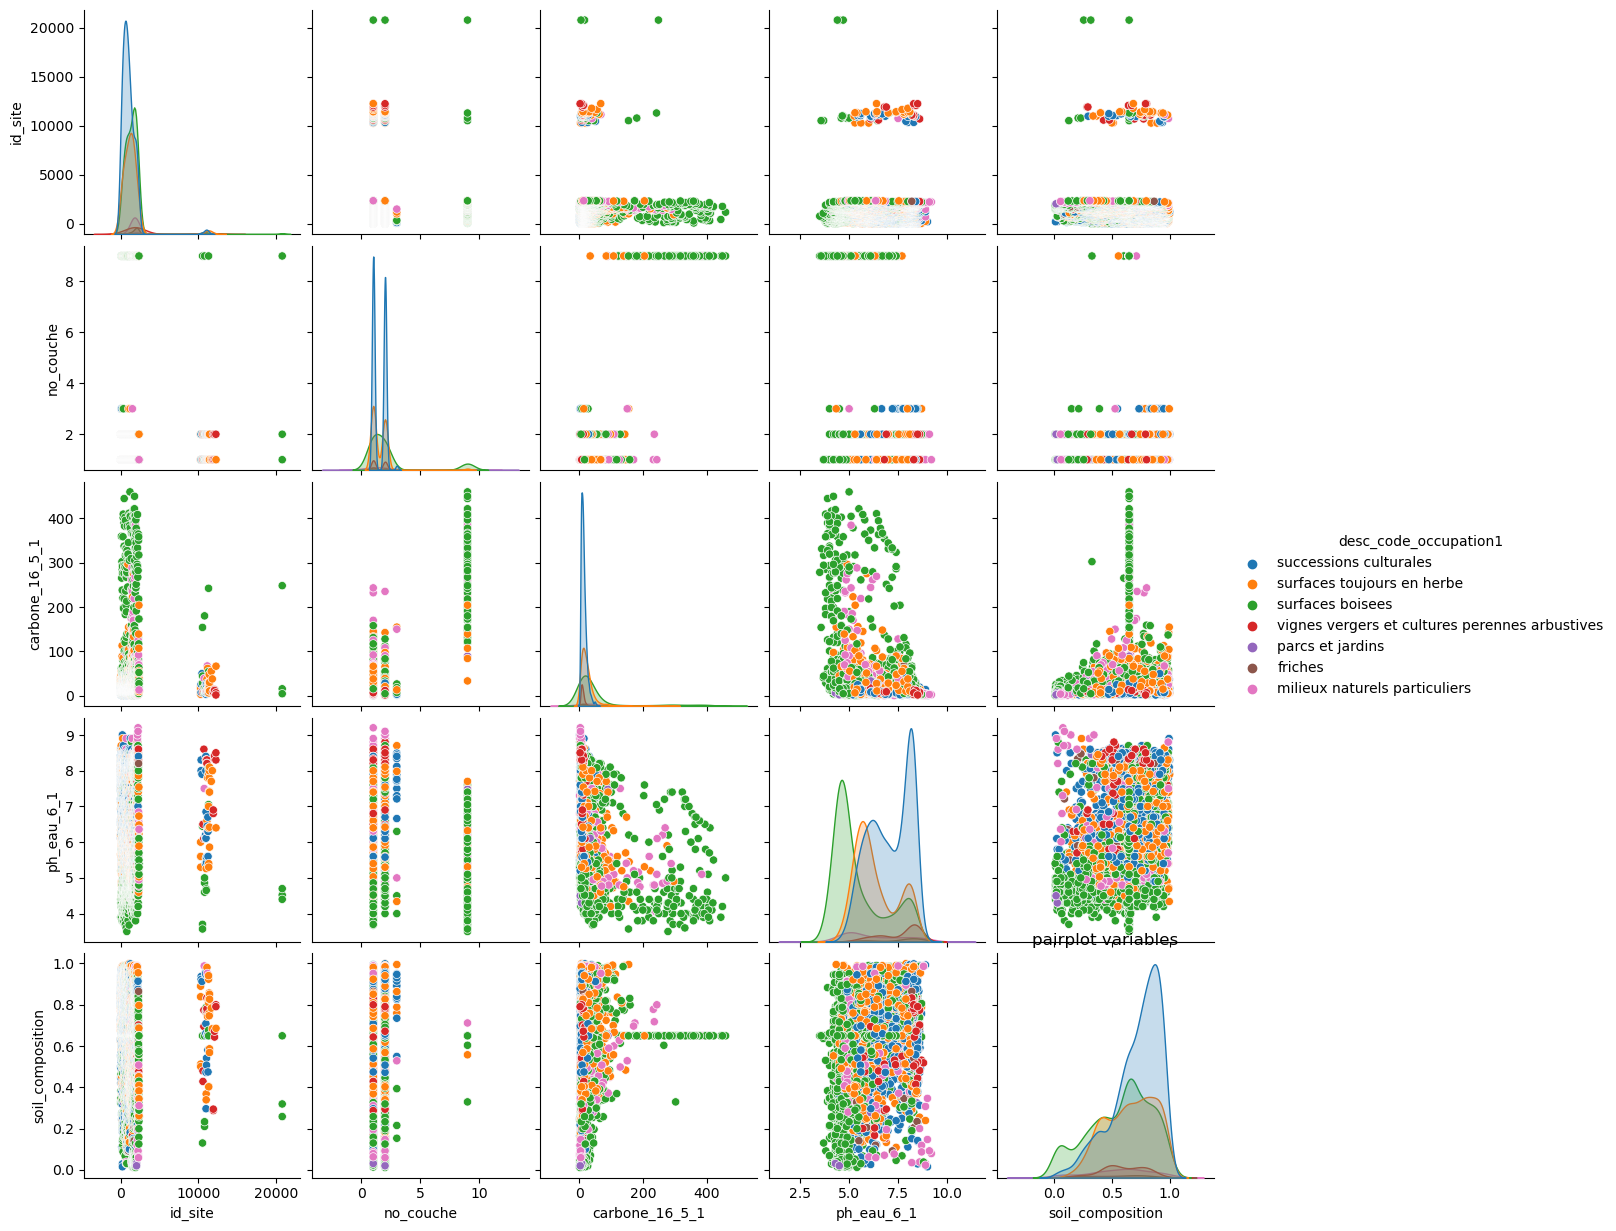

In [38]:
plt.figure(figsize=(8, 6))  
sns.pairplot(df[['id_site', 'no_couche', 'carbone_16_5_1','ph_eau_6_1', 'soil_composition',
       'desc_code_occupation1', 'desc_code_occupation3']],hue="desc_code_occupation1")
plt.title('pairplot variables')  
plt.show()  

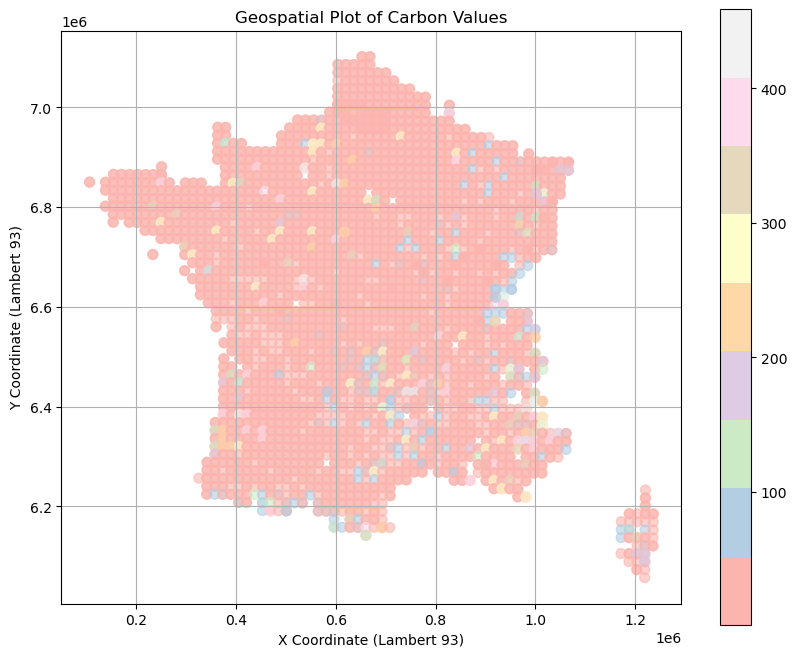

In [39]:
# Create a GeoDataFrame  
geometry = [Point(xy) for xy in zip(df['x_theo'], df['y_theo'])]  
gdf = gpd.GeoDataFrame({'carbon': df['carbone_16_5_1']}, geometry=geometry)  

# Plotting  
fig, ax = plt.subplots(figsize=(10, 8))  
gdf.plot(column='carbon', ax=ax, legend=True, cmap='Pastel1',  
          markersize=50, alpha=0.6)  

plt.title('Geospatial Plot of Carbon Values')  
plt.xlabel('X Coordinate (Lambert 93)')  
plt.ylabel('Y Coordinate (Lambert 93)')  
plt.grid()  
plt.show()

In [40]:
df.head(2)

,id_site,no_couche,carbone_16_5_1,ph_eau_6_1,soil_composition,desc_code_occupation1,desc_code_occupation3,x_theo,y_theo,avg_temp,avg_prec
0,6,1,12.920,8.16,0.500,successions culturales,grandes cultures et prairies courte duree,652326.99,7101219.71,10.275,58.55
1,6,2,5.247,8.42,0.624,successions culturales,grandes cultures et prairies courte duree,652326.99,7101219.71,10.275,58.55


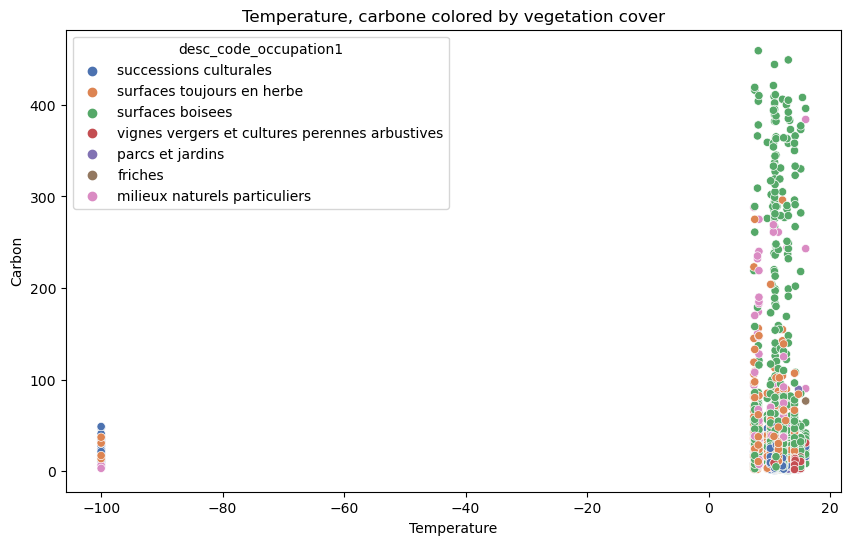

In [41]:
# 3. Scatter plot: Temperature, carbone colored by vegetation cover
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_temp', y='carbone_16_5_1', hue='desc_code_occupation1', data=df, palette='deep')
plt.title('Temperature, carbone colored by vegetation cover')
plt.xlabel('Temperature')
plt.ylabel('Carbon')
plt.legend(title="desc_code_occupation1")
plt.show()

## Transform categorical variables on numeric
The column `desc_code_occupation3` contains an excessive number of unique values, making it challenging to transform into a numerical format suitable for modeling. Since I also have `desc_code_occupation1`, which presumably serves a similar purpose, I prefer to retain this latter column and drop `desc_code_occupation3` from the dataset. This decision simplifies the data preparation process by eliminating the complication of handling a high cardinality feature that may not contribute additional value to the analysis.


In [42]:
df_dummies = pd.get_dummies(df, columns=['desc_code_occupation1'], drop_first=True)  
df_dummies.head()

,id_site,no_couche,carbone_16_5_1,ph_eau_6_1,soil_composition,desc_code_occupation3,x_theo,y_theo,avg_temp,avg_prec,desc_code_occupation1_milieux naturels particuliers,desc_code_occupation1_parcs et jardins,desc_code_occupation1_successions culturales,desc_code_occupation1_surfaces boisees,desc_code_occupation1_surfaces toujours en herbe,desc_code_occupation1_vignes vergers et cultures perennes arbustives
0,6,1,12.920,8.16,0.500,grandes cultures et prairies courte duree,652326.99,7101219.71,10.275,58.55,0,0,1,0,0,0
1,6,2,5.247,8.42,0.624,grandes cultures et prairies courte duree,652326.99,7101219.71,10.275,58.55,0,0,1,0,0,0
2,7,1,14.300,8.20,0.552,systeme de rotations sans prairie sans intercu...,668319.25,7101085.53,10.275,58.55,0,0,1,0,0,0
3,7,2,7.450,8.30,0.850,systeme de rotations sans prairie sans intercu...,668319.25,7101085.53,10.275,58.55,0,0,1,0,0,0
4,8,1,37.513,7.56,0.674,STH > 10 ans naturelle ou semee,604216.81,7085629.01,10.275,58.55,0,0,0,0,1,0


# Modelisation

## train test split

In [43]:
X = df_dummies.drop(columns=['carbone_16_5_1',"id_site","desc_code_occupation3"])  # Features  
y = df_dummies['carbone_16_5_1']  

In [44]:
# use 20% of data for test set and the rest on train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
It is a key step to ensuring that models treat all variables on an equal basis, which often enhances the performance and stability of machine learning models.


In [45]:
df.columns

Index(['id_site', 'no_couche', 'carbone_16_5_1', 'ph_eau_6_1',
       'soil_composition', 'desc_code_occupation1', 'desc_code_occupation3',
       'x_theo', 'y_theo', 'avg_temp', 'avg_prec'],
      dtype='object')

In [46]:
columns_to_standardize = ['ph_eau_6_1', 'soil_composition']
scaler = StandardScaler()  

In [47]:
X_train[['ph_eau_6_1', 'soil_composition']] = scaler.fit_transform(X_train[['ph_eau_6_1', 'soil_composition']])

In [48]:
X_test[['ph_eau_6_1', 'soil_composition']] = scaler.fit_transform(X_test[['ph_eau_6_1', 'soil_composition']])

## training the model
As part of our analysis, we decided to go with a regression model to predict the target variable based on the various features of our dataset. Regression is especially well-suited for this kind of problem because it allows us to quantify the relationship between the independent variables and the dependent variable.

We chose this model because of its simplicity and effectiveness in handling continuous data.

In [49]:
# Create the model  
model = RandomForestRegressor(n_estimators=200, random_state=42)  # n_estimators is the number of trees  

# Train the model  
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [50]:
# Make predictions  
y_pred = model.predict(X_test)

In [51]:
# comparaison of trues values and predicted
print(y_pred[:5], y_test[:5].values)

[ 8.17198  10.84634  47.166435  9.50059  25.295085] [ 8.42  10.221 30.2    6.27  61.2  ]


#  Perform an assessment on the quality of the model and comment on what you see. Do you see a possibility of being able to use this for predictions? 

Predicted values: [ 8.17198  10.84634  47.166435  9.50059  25.295085]
Actual test values: [ 8.42  10.221 30.2    6.27  61.2  ]


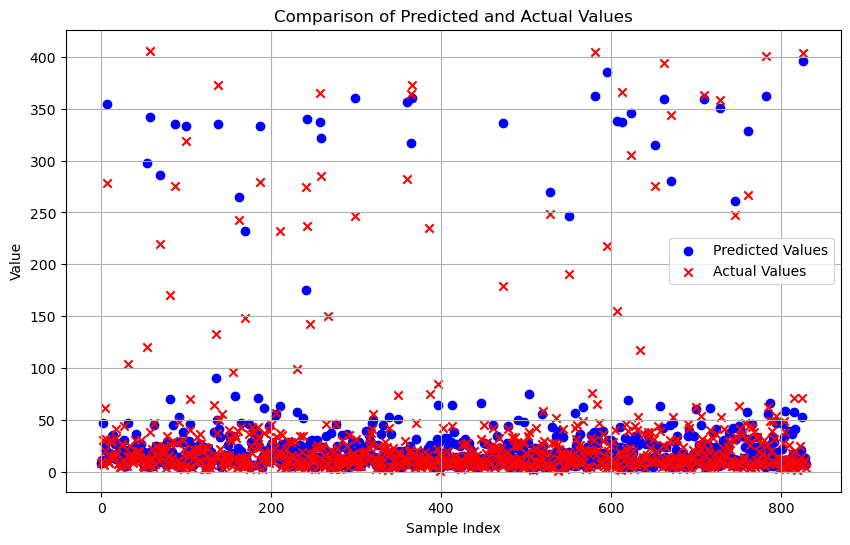

In [52]:
import matplotlib.pyplot as plt  


# Display the first five predicted values and the first five actual test values  
print("Predicted values:", y_pred[:5])  
print("Actual test values:", y_test[:5].values)  

# Create a scatter plot  
plt.figure(figsize=(10, 6))  
plt.scatter(range(len(y_pred)), y_pred, color='blue', label='Predicted Values', marker='o')  
plt.scatter(range(len(y_test)), y_test, color='red', label='Actual Values', marker='x')  

# Adding titles and labels  
plt.title('Comparison of Predicted and Actual Values')  
plt.xlabel('Sample Index')  
plt.ylabel('Value')  
plt.legend()  
plt.grid()  

# Show the plot  
plt.show()

See the 5 first values above. The prediction is not too bad

In [53]:
# Evaluate the model using Mean Squared Error and R² score  
mse = mean_squared_error(y_test, y_pred)  
r2 = r2_score(y_test, y_pred)  

print(f'Mean Squared Error: {mse}')  
print(f'R² Score: {r2}')

Mean Squared Error: 498.6354489767397
R² Score: 0.8641213314366103


The evaluation metrics suggest that the model performed moderately.
192.85 of error metrics and a mean R² score ~ 56%), then the model is likely capable of making reliable predictions.further improvements may be necessary before using it for predictions.

## What options do we have to make the model perform better?

Options to Improve Model Performance

1. Feature Engineering:

            Create new features based on domain knowledge or data exploration.
            For example the precipitations data would be more relevant than other variables on the dataset. Also maybe include time variable.

2. Hyperparameter Tuning:

Use techniques like Grid Search or Random Search to find the optimal hyperparameters for the model, which can greatly enhance performance.


3. Ensemble Methods:

Combine predictions from multiple models (e.g., bagging, boosting) to potentially achieve better performance than a single model.

4. Increase Data:

If possible, gather more data or improve the quality of existing data, as larger datasets can lead to better model training.

5. Model Selection:

Explore different modeling algorithms (polynomial regression, support vector regression, or tree-based ensemble methods like Gradient Boosting) that might capture the underlying relationships more effectively than the current model. Maybe try times series models if time data is added.


Conclusion
In summary, by rigorously assessing the model's quality through appropriate metrics and diagnostics, you can determine its current predictive capability. Should the model reveal room for improvement, various strategies—including feature engineering, hyperparameter tuning, and exploring alternative modeling techniques—can enhance its performance, ultimately leading to better prediction capabilities.

Additionally, I would have appreciated more time to thoroughly analyze the data. With more time, I could delve deeper into the datasets, uncovering insights and patterns that may not have been immediately apparent. This additional analysis would allow for a more comprehensive understanding of the data, potentially leading to more informed decisions and improved model performance.